In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import datetime
import os
import numpy as np
import tensorflow as tf
import keras
import sklearn.model_selection as sk
import copy
from PIL import Image as IM
from keras.callbacks import TensorBoard
import cv2
import json
import pathlib
import glob
from collections import Counter
import seaborn as sns

Using TensorFlow backend.


In [2]:
def normalize(a, min, max, scale_min=0, scale_max=255, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to scale_min-scale_max
        Optionally specify the data type of the output
    """
    return (scale_min + (((a - min) / float(max - min)) * scale_max)).astype(dtype)

In [16]:
def load_bin_file(bin_path):
    '''
    Load a binary file and convert it into a numpy array.
    '''
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [37]:
def plot(imgs, labels=None, cmap='gray', figsize=(20,10), fontsize=30):
    '''
    Displays images and labels in a plot
    '''
    nrows, ncols = len(imgs), len(imgs[0])
    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1 or ncols == 1:
        axes = [axes]
    if nrows == 1 and ncols == 1:
        axes = [axes]
    for i in range(0, nrows):
        for j in range(0, ncols):
            try:
                axes[i][j].imshow(imgs[i][j], cmap=cmap)
                if labels is not None:
                    axes[i][j].set_title(labels[i][j], fontsize=fontsize)
            except IndexError as err:
                continue
    return axes

In [30]:
def filter_points(points, side_range=None, fwd_range=None, \
                  height_range=None, intensity_range=None, \
                  horizontal_fov=None, vertical_fov=None):
    '''
    Returns filtered points based on side(y), forward(x) and height(z) range,
    horizontal and vertical field of view, and intensity.
    '''
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    i = points[:, 3]
    
    mask = np.full_like(x, True)
    
    if side_range is not None:
        side_mask = np.logical_and((y > -side_range[1]), (y < -side_range[0]))
        mask = np.logical_and(mask, side_mask)

    if fwd_range is not None:
        fwd_mask = np.logical_and((x > fwd_range[0]), (x < fwd_range[1]))
        mask = np.logical_and(mask, fwd_mask)

    if height_range is not None:
        height_mask = np.logical_and((z > height_range[0]), (z < height_range[1]))
        mask = np.logical_and(mask, height_mask)
    
    if intensity_range is not None:
        intensity_mask = np.logical_and((i > intensity_range[0]), (i < intensity_range[1]))
        mask = np.logical_and(mask, intensity_mask)
        
    if horizontal_fov is not None:
        horizontal_fov_mask = np.logical_and(np.arctan2(y, x) > (-horizontal_fov[1] * np.pi / 180), \
                          np.arctan2(y, x) < (-horizontal_fov[0] * np.pi / 180))
        mask = np.logical_and(mask, horizontal_fov_mask)
    
    if vertical_fov is not None:
        distance = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        vertical_fov_mask = np.logical_and(np.arctan2(z,distance) < (vertical_fov[1] * np.pi / 180), \
                          np.arctan2(z,distance) > (vertical_fov[0] * np.pi / 180))
        mask = np.logical_and(mask, vertical_fov_mask)

    indices = np.argwhere(mask).flatten()
    x_filtered = x[indices]
    y_filtered = y[indices]
    z_filtered = z[indices]
    i_filtered = i[indices]
    return np.vstack([x_filtered, y_filtered, z_filtered, i_filtered]).T

In [31]:
def get_bev(points, resolution=0.1, side_range=None, fwd_range=None, \
            pixel_values=None, generate_img=None):
    '''
    Returns bird's eye view of a LiDAR point cloud for a given resolution.
    Optional pixel_values can be used for giving color coded info the point cloud.
    Optional generate_img function can be used for creating images.
    '''
    x_range = side_range
    y_range = fwd_range
    _points = filter_points(points, side_range=x_range, fwd_range=y_range)
    x = _points[:, 0]
    y = _points[:, 1]
    z = _points[:, 2]
    
    if x_range is None:
        x_range = -1 * np.ceil(y.max()).astype(np.int), ((y.min()/np.abs(y.min())) * np.floor(y.min())).astype(np.int)
    
    if y_range is None:
        y_range = np.floor(x.min()).astype(np.int), np.ceil(x.max()).astype(np.int)
    
    # Create mapping from a 3D point to a pixel based on resolution
    # floor() used to prevent issues with -ve vals rounding upwards causing index out bound error
    x_img = (-y / resolution).astype(np.int32) - int(np.floor(x_range[0]/resolution))
    y_img = (x / resolution).astype(np.int32) - int(np.floor(y_range[0]/resolution))

    img_width  = int((x_range[1] - x_range[0])/resolution)
    img_height = int((y_range[1] - y_range[0])/resolution)

    if pixel_values is None:
        pixel_values = (((z - z.min()) / float(z.max() - z.min())) * 255).astype(np.uint8)

    if generate_img is None:
        img = np.zeros([img_height, img_width], dtype=np.uint8)
        img[-y_img, x_img] = pixel_values
        return img
    
    return generate_img(img_height, img_width, -y_img, x_img, pixel_values)

In [32]:
def get_features(points):
    '''
    Returns features of the point cloud as stacked grayscale images.
    Shape of the output is (400x200x6).
    '''
    side_range=(-10, 10)
    fwd_range=(6, 46)
    res=.1
    min_height = -2.73
    max_height = 1.27
    max_points_per_grid = 500

    # calculate the image dimensions
    img_width = int((side_range[1] - side_range[0])/res)
    img_height = int((fwd_range[1] - fwd_range[0])/res)
    number_of_grids = img_height * img_width


    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    r_lidar = points[:, 3]
    
    # NORMALIZATION
    # Normalise the elevation, reflectance, and count
    # count will be normalised afterwards
    # reflectance range [0.0 - 1.0] in KITTI(already normalised) or [0 - 255] from sensor output. 

    # clip elevation values
    clipped_z_lidar = np.clip(z_lidar, min_height, max_height)
    # normalise elevation in range [0 - 1]
    norm_z_lidar = (clipped_z_lidar - min_height) / (max_height - min_height)
    # norm_z_lidar = clipped_z_lidar - min_height

    # MAPPING
    # Mappings from one point to grid 
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution(grid size)
    x_img_mapping = (-y_lidar/res).astype(np.int32) # x axis is -y in LIDAR
    y_img_mapping = (x_lidar/res).astype(np.int32)  # y axis is -x in LIDAR; will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img_mapping -= int(np.floor(side_range[0]/res))
    y_img_mapping -= int(np.floor(fwd_range[0]/res))

    # Linerize the mappings to 1D
    lidx = ((-y_img_mapping) % img_height) * img_width + x_img_mapping

    # Feature extraction
    # count of points per grid
    count_input = np.ones_like(norm_z_lidar)
    binned_count = np.bincount(lidx, count_input, minlength = number_of_grids)
    # sum reflectance
    binned_reflectance =  np.bincount(lidx, r_lidar, minlength = number_of_grids)

    # sum elevation 
    binned_elevation = np.bincount(lidx, norm_z_lidar, minlength = number_of_grids)

    # Finding mean!
    binned_mean_reflectance = np.divide(binned_reflectance, binned_count, out=np.zeros_like(binned_reflectance), where=binned_count!=0.0)
    binned_mean_elevation = np.divide(binned_elevation, binned_count, out=np.zeros_like(binned_elevation), where=binned_count!=0.0)
    o_mean_elevation = binned_mean_elevation.reshape(img_height, img_width)

    # Standard devation stuff
    binned_sum_var_elevation = np.bincount(lidx, np.square(norm_z_lidar - o_mean_elevation[-y_img_mapping, x_img_mapping]), minlength = number_of_grids)
    binned_divide = np.divide(binned_sum_var_elevation, binned_count, out=np.zeros_like(binned_sum_var_elevation), where=binned_count!=0.0)
    binned_std_elevation = np.sqrt(binned_divide)

    # minimum and maximum
    sidx = lidx.argsort()
    idx = lidx[sidx]
    val = norm_z_lidar[sidx]

    m_idx = np.flatnonzero(np.r_[True,idx[:-1] != idx[1:]])
    unq_ids = idx[m_idx]

    o_max_elevation = np.zeros([img_height, img_width], dtype=np.float64)
    o_min_elevation = np.zeros([img_height, img_width], dtype=np.float64)

    o_max_elevation.flat[unq_ids] = np.maximum.reduceat(val, m_idx)
    o_min_elevation.flat[unq_ids] = np.minimum.reduceat(val, m_idx)

    # Normalise things
    norm_binned_count = binned_count / max_points_per_grid
    # reshape all other things
    o_count            = norm_binned_count.reshape(img_height, img_width)
    o_mean_reflectance = binned_mean_reflectance.reshape(img_height, img_width)
    o_std_elevation    = binned_std_elevation.reshape(img_height, img_width)
    return np.dstack([o_count, o_mean_reflectance, o_max_elevation, o_min_elevation, o_mean_elevation, o_std_elevation])

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f70ebc1b630>]]

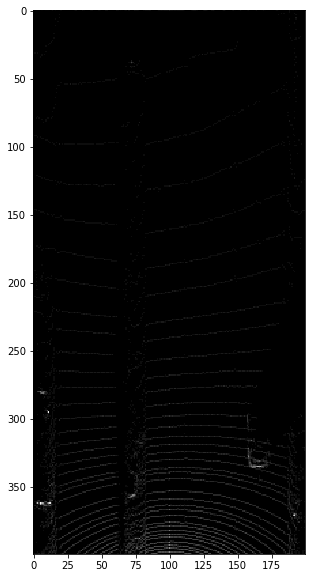

In [42]:
points = load_bin_file('kitti_sample.bin')
features = get_features(filter_points(points, side_range=(-10, 10), fwd_range=(6, 46)))
plot([[features[:,:,0]]])